# Network Reduction: Filtering

We want to construct a network that contains less data than the original graph to allow us to highlight some specific features of the network or to make it tractable from a computational standpoint.

#### Network coarse-graining: 
* Next class!

#### Network Filtering:

* Thresholding (on vertex or edge properties)
* K-core Decomposition
* Minimum Spanning Tree
* Disparity Filtering (aka Backbone Extraction)

In [3]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
import scipy as sp

from scipy.sparse import linalg, csr_matrix
from operator import itemgetter
import scipy.stats as stats
from numpy import genfromtxt

from scipy.sparse.linalg import eigsh
from scipy.sparse import diags
from scipy.spatial.distance import cosine as cosine_distance
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import seaborn as sns
from collections import defaultdict
from random import shuffle

#stats.kendalltau is for two arrays. We have centralities as dictionary

%matplotlib inline

## Data

The data we are going to use include information about the flow of passengers between two airports in year 2010.

Source: Opsahl, T., 2011. Why Anchorage is not (that) important: Binary ties and Sample selection. 

In [4]:
from collections import defaultdict
edges = defaultdict(float)
with open('./data/openflights_USairport_2010.txt','r') as fp:
    for line in fp:
        source_node,target_node,passengers = map(float,line.strip().split())
        edge = (source_node,target_node) if source_node<target_node else (target_node,source_node)
        edges[edge]+=0.5*passengers
        

In [5]:
import csv
airports = {}
with open('./data/openflights_airports.txt','r') as fp:
    header = fp.readline().strip().split()
    csvreader = csv.reader(fp,delimiter = ' ', )
    # "Airport ID" "Name" "City" "Country" "IATA/FAA" "ICAO" "Latitude" "Longitude" "Altitude" "Timezone" "DST"
    for line in csvreader:
        airports[float(line[0])] = {'name':line[1], 'label':line[4], 'city':line[2], 'country':line[2],
                                    'latitude':float(line[6]), 'longitude':float(line[7])}

In [12]:
edges

defaultdict(float,
            {(1264.0, 1328.0): 149.5,
             (548.0, 585.0): 4.0,
             (1433.0, 1521.0): 24481.5,
             (628.0, 1763.0): 5996.0,
             (127.0, 1252.0): 66932.5,
             (918.0, 1359.0): 11.0,
             (246.0, 526.0): 296435.0,
             (686.0, 731.0): 12.0,
             (123.0, 1541.0): 283.0,
             (234.0, 619.0): 4.5,
             (293.0, 759.0): 0.5,
             (760.0, 1162.0): 1086.0,
             (317.0, 1270.0): 45805.5,
             (1004.0, 1645.0): 9.0,
             (215.0, 758.0): 138.5,
             (902.0, 994.0): 103102.5,
             (246.0, 296.0): 644.0,
             (526.0, 910.0): 1.5,
             (104.0, 273.0): 3.0,
             (1462.0, 1706.0): 3.5,
             (256.0, 534.0): 1.5,
             (902.0, 1353.0): 246476.0,
             (591.0, 1016.0): 12111.0,
             (296.0, 1783.0): 1.0,
             (317.0, 435.0): 330601.5,
             (432.0, 1527.0): 188.5,
             (381.0, 972.

In [11]:
airports[1]

{'city': 'Goroka',
 'country': 'Goroka',
 'label': 'GKA',
 'latitude': -6.081689,
 'longitude': 145.391881,
 'name': 'Goroka'}

In [8]:
# Create Networkx graph
G = nx.Graph()
G.add_edges_from(map(lambda (k,v):(k[0],k[1],{'weight':v}), edges.iteritems()))

In [9]:
N = G.number_of_nodes()
M = G.number_of_edges()
print "Number of Airports:", N
print "Number of Connections:", M

Number of Airports: 1574
Number of Connections: 17215


In [11]:
def get_binning(values, number_of_bins = 50, log_binning = False, base = 2):
    # We need to define the support of our distribution
    lower_bound = min(values)
    upper_bound = max(values)
    # And the bins
    if log_binning:
        log = np.log2 if base == 2 else np.log10
        lower_bound = log(lower_bound) if lower_bound >= 1 else 0.0
        upper_bound = log(upper_bound)
        bins = np.logspace(lower_bound,upper_bound,number_of_bins, base = base)
    else:
        bins = np.linspace(lower_bound,upper_bound,number_of_bins)
    # Then we can compute the histogram using numpy
    y, __ = np.histogram(values, 
                           bins = bins,
                           density=True)
    # Now, we need to compute for each y the value of x
    x = bins[1:] - np.diff(bins)/2.0        
    return x,y

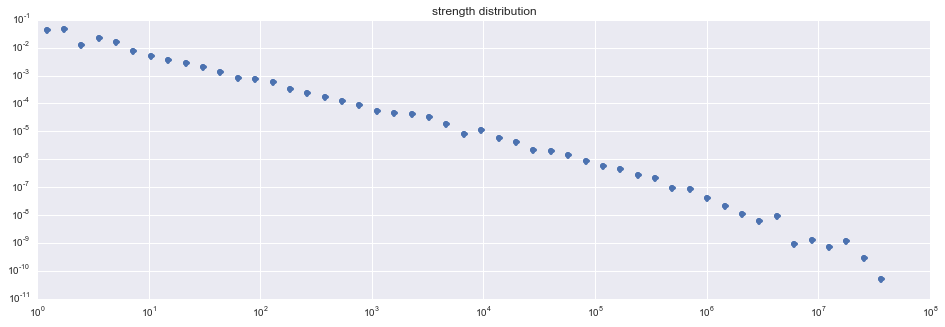

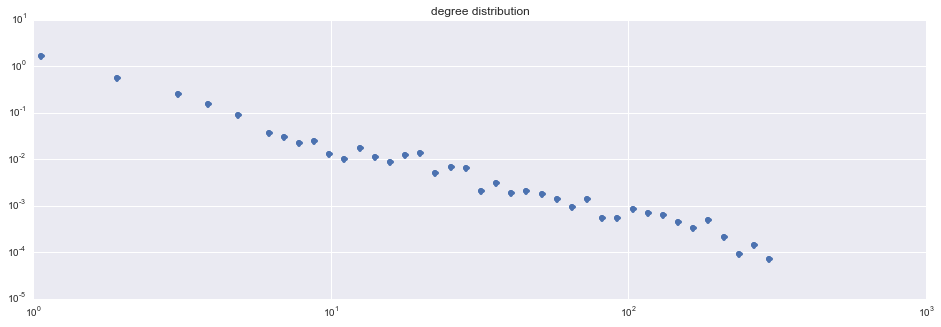

In [12]:
# Plot degree and strength distributions
stats = {}
stats['degree'] = G.degree().values()
stats['strength'] = G.degree(weight='weight').values()


for stat,values in stats.iteritems():
    plt.figure(figsize=(16,5))
    x,y = get_binning(values,log_binning=True)
    __ = plt.loglog(x,y,'o',label=stat)
    plt.title("%s distribution" % stat)

# Thresholding

___Thresholding___ is the simplest technique one can employ to filter/prune a graph. 
It consists in defining an (arbitrary) threshold to filter out edges that have a weight below a given cutoff value.



The main problems of this method are:
* it does not preserve the hierarchical organization of a network
* it does not take into account for the heterogeneity of the system (especially when the distribution of edge weights lack a characteristic scale)

## Example

In [ ]:
def get_filtered_graph(G,w_threshold):
    G_filtered = nx.Graph()
    for node_i, node_j in G.edges_iter():
        w = G[node_i][node_j]['weight']
        if w>w_threshold:
            G_filtered.add_edge(node_i,node_j, {'weight':w})
    return G_filtered

weights = nx.get_edge_attributes(G,'weight').values()
min_w = np.min(weights)
max_w = np.max(weights)
w_thresholds = np.logspace(np.log10(min_w),np.log10(max_w)-1,10)
#w_thresholds = np.linspace(min_w,max_w-1,10)

# Plot degree distribution
plt.figure(figsize=(16,5))
for w_threshold in w_thresholds:
    G_filtered = get_filtered_graph(G,w_threshold)
    print 'w_threshold: %s (%1.2f%% nodes)' % (w_threshold, 100.*G_filtered.number_of_nodes()/N)
    degrees_filtered = G_filtered.degree().values()
    x,y = get_binning(degrees_filtered,log_binning=True)
    __ = plt.loglog(x,y,'o',label='Threshold: %1.7f' % w_threshold)

x,y = get_binning(stats['degree'],log_binning=True)
__ = plt.loglog(x,y,'-o',label='True')
    
plt.legend()
    
plt.title("Degree distribution")



# Plot edge weights distribution
plt.figure(figsize=(16,5))
for w_threshold in w_thresholds:
    G_filtered = get_filtered_graph(G,w_threshold)
    print 'w_threshold: %s (%1.2f%% nodes)' % (w_threshold, 100.*G_filtered.number_of_nodes()/N)
    weights_filtered = nx.get_edge_attributes(G_filtered,'weight').values()
    x,y = get_binning(weights_filtered,log_binning=True)
    __ = plt.loglog(x,y,'o',label='w_threshold: %1.7f' % w_threshold)

weights_original = nx.get_edge_attributes(G,'weight').values()
x,y = get_binning(weights_original,log_binning=True)
__ = plt.loglog(x,y,'-o',label='True')
    
plt.legend()
    
plt.title("Edge Weights distribution")

w_threshold: 0.5 (98.41% nodes)
w_threshold: 2.0282858296 (92.69% nodes)
w_threshold: 8.22788681312 (83.35% nodes)
w_threshold: 33.3770124612 (75.79% nodes)
w_threshold: 135.396242819 (67.15% nodes)
w_threshold: 549.244561382 (57.12% nodes)
w_threshold: 2228.04992167 (48.35% nodes)
w_threshold: 9038.24416755 (37.42% nodes)
w_threshold: 36664.2851391 (25.48% nodes)
w_threshold: 148731.3 (11.18% nodes)


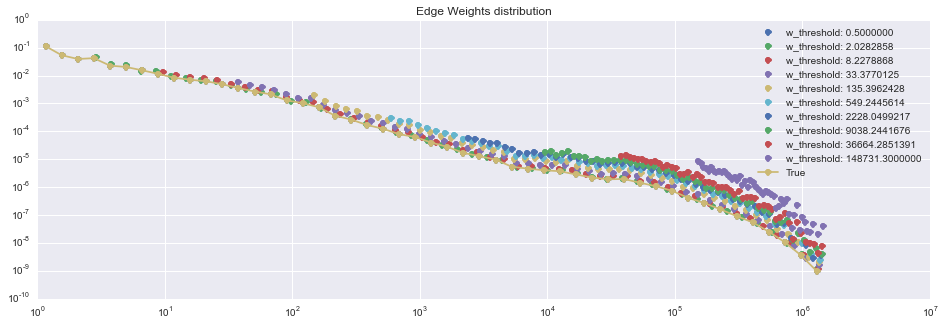

# K-core Decomposition

The ___k-core decomposition___ can be used to visualize large scale networks by recursively pruning the least connected vertices. This also allows to disentangle the hierarchical structure of the graph by progressively focusing on their central cores. 

A ___k-core___ of a graph $G = (V,S)$ is a maximal connected subgraph of $G$ in which all vertices have degree at least $k$. In practice, a k-core of $G$ can be obtained by recursively removing all the vertices of degree less than $k$, until all vertices in the remaining graph have at least degree $k$.

A node $i$ is said to have  ___coreness___ $c_i = k$ if and only if vertex $i$ belongs to the $k$-core but not to the $(k+1)$-core of graph $G$. 

Lastly, a ___shell___ $C_k$ is a vertex-induced subgraph $G'=(V',E')$ of $G$ such that $\forall i \in V'$, $c_i = k$. 

<img src="./images/coreness.png" alt="Coreness" width="600">

The coreness of each node can be used to create a two dimensional graphical layout of the graph where vertices belonging to different k-shells are assigned to different circular shells, with the nodes with the highest coreness displayed at the center of the plot.

<img src="./images/coreness1.png" alt="Coreness1" width="1100">

## Example

In [17]:
# Homework 4

# Minimum Spanning Tree

A ___spanning tree___ $T$ of an undirected graph $G$ is a subgraph in which any two vertices are connected by exactly one path and which includes all of the vertices of $G$. 

A ___minimum spanning tree___ is a spanning tree of a connected, undirected graph that connects all the vertices together with the minimal total weighting for its edges.



<img src="https://upload.wikimedia.org/wikipedia/commons/d/d2/Minimum_spanning_tree.svg"  width="600">

### Example

In [18]:
# Homework 4

## Possible applications

### Epidemics

On an ___infection network___, each directed edge weight represents the probability of the source node being
responsible for introducing the disease on the target node. The ___infection tree___ is built by taking into account the paths with higher probability. In this case, the cost of each edge $w_{i,j}$ is given by the probability $1 − p_{i,j}$ where $p_{i,j}$ is the (average) probability that the infection will propagate along the connection linking node $i$ to node $j$.

<img src="./images/MST.png" alt="Coreness1" width="700">

<img src="./images/MST2.png" alt="Coreness1" width="700">

### Financial Networks

Let us consider the ___daily price returns___ of a set of $N$ different financial assets. We can compute a $N\times N$ correlation matrix of the individual daily returns $r_i(t)$ of asset $i$ at day $t$. Then, we can associate a ___metric distance___ to each correlation coefficient $\rho_{i,j}$: $d_{i,j} = \sqrt{2(1-\rho_{i,j})}$ and compute the minimum spanning tree of the correlation-based graph generated using the $N \times N$ matrix of distances.

<img src="./images/MSTfin1.png" alt="Coreness1" width="500">

<img src="./images/MSTfin2.png" alt="Coreness1" width="500">

The color of each node (i.e. asset) represents its main industry sector according to the Standard Industrial Classification (SIC) system.

# Disparity Filter (Graph Backbone Extraction)

The ___disparity filter___ method is based on the local identification of the _statistically
significant_ weight heterogeneities and it is able to extract the _backbone_ of dominant connections in weighted networks. This algorithm preserves the structural properties and hierarchies of the graph at all scales, even in the presence of high heterogeneity. In the following, we describe how this method works.

First, _edge weights_ are ___normalized___. Let $s_i$ denote the strength of node $i$ and $w_{i,j}$ the weight associated to the edge connecting node $i$ with node $j$, then the normalized weight of edge $e_{i,j}$ is computed as:
$$ p_{i,j} = \frac{w_{i,j}}{s_i} .$$

Second, a ___null model___ is defined to characterize the (random) distribution of weights associated to the connections of a particular node $i$. In particular, we assume that for each node $i$ of degree $k_i$, the normalized weights associated to the $k_i$ edges incident to $i$ are produced by a random assignment from a uniform distribution in the interval $[0,1]$.

Therefore, under the null hypothesis, the probability of observing a certain $p_{i,j}$ is given by:
$$ \alpha_{i,j} = 1 - (k_i-1) \int_0^{p_{i,j}} (1-x)^{k_i-2} dx .$$

Third, we fix a ___significance level___ $\alpha$ to determine when to reject the null hypothesis that a normalized edge weight comes from the random distribution assumed by the null model. Put it differently, whenever
$$ \alpha_{i,j} < \alpha $$
an edge will be considered statistically significant.

Note: an edge is part of the backbone graph as long as it is statistically significant for at least one of the nodes incident to it. In the case in which the degree of one of the two nodes is equal to 1, the connection is mantained only if the above condition is satisfied for the node having a degree greater than 1.

## Example

In [19]:
def get_backbone_graph(G,alpha):
    degrees = G.degree()
    strengths = G.degree(weight='weight')
    
    G_backbone = nx.Graph()
    
    for node_i, node_j in G.edges_iter():
        w = G[node_i][node_j]['weight']
        
        if degrees[node_i]>1 and degrees[node_j]>1:        

            p_ij_i = w/float(strengths[node_i])
            p_ij_j = w/float(strengths[node_j])

            alpha_ij_i = (1.0 - p_ij_i)**(degrees[node_i]-1.0)
            alpha_ij_j = (1.0 - p_ij_j)**(degrees[node_j]-1.0)
            
            if alpha_ij_i < alpha or alpha_ij_j < alpha:
                G_backbone.add_edge(node_i,node_j,{'weight':w})
            
        elif degrees[node_i]>1 and degrees[node_j]==1:        
            p_ij_i = w/float(strengths[node_i])
            alpha_ij_i = (1.0 - p_ij_i)**(degrees[node_i]-1.0)

            if alpha_ij_i < alpha:
                G_backbone.add_edge(node_i,node_j,{'weight':w})

        elif degrees[node_j]>1 and degrees[node_i]==1:        
            p_ij_j = w/float(strengths[node_j])
            alpha_ij_j = (1.0 - p_ij_j)**(degrees[node_j]-1.0)

            if alpha_ij_j < alpha:
                G_backbone.add_edge(node_i,node_j,{'weight':w})
        
            
    return G_backbone

In [20]:
import numpy as np
import networkx as nx

In [21]:
# Extracting the backbone
share_nodes = []
share_edges = []
share_strength = []
alphas = np.linspace(0.5,1.0,101)
total_strength = nx.adj_matrix(G).sum()
for alpha in alphas:
    print alpha,
    G_backbone = get_backbone_graph(G,alpha)
    N_b = G_backbone.number_of_nodes()
    M_b = G_backbone.number_of_edges()
    total_strength_b = nx.adj_matrix(G_backbone).sum()
    
    share_nodes.append(N_b/float(N))
    share_edges.append(M_b/float(M))
    share_strength.append(total_strength_b/total_strength)

0.5 0.505 0.51 0.515 0.52 0.525 0.53 0.535 0.54 0.545 0.55 0.555 0.56 0.565 0.57 0.575 0.58 0.585 0.59 0.595 0.6 0.605 0.61 0.615 0.62 0.625 0.63 0.635 0.64 0.645 0.65 0.655 0.66 0.665 0.67 0.675 0.68 0.685 0.69 0.695 0.7 0.705 0.71 0.715 0.72 0.725 0.73 0.735 0.74 0.745 0.75 0.755 0.76 0.765 0.77 0.775 0.78 0.785 0.79 0.795 0.8 0.805 0.81 0.815 0.82 0.825 0.83 0.835 0.84 0.845 0.85 0.855 0.86 0.865 0.87 0.875 0.88 0.885 0.89 0.895 0.9 0.905 0.91 0.915 0.92 0.925 0.93 0.935 0.94 0.945 0.95 0.955 0.96 0.965 0.97 0.975 0.98 0.985 0.99 0.995 1.0


alpha: 1e-07 (25.22% nodes)
alpha: 1e-06 (28.84% nodes)
alpha: 1e-05 (32.66% nodes)
alpha: 0.0001 (38.44% nodes)
alpha: 0.001 (45.62% nodes)
alpha: 0.01 (52.92% nodes)
alpha: 0.1 (63.79% nodes)


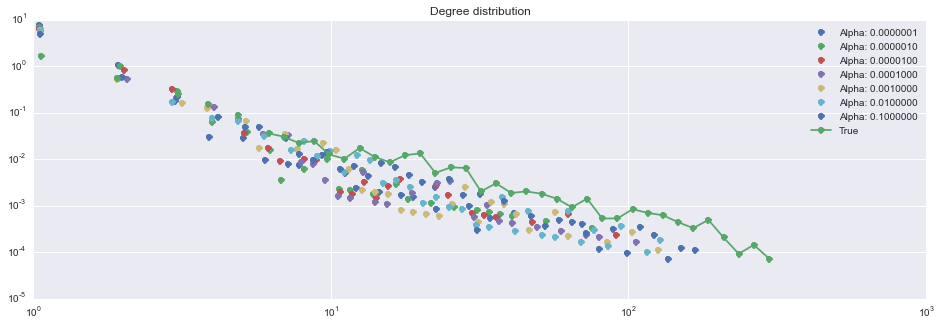

In [23]:
# Degree distribution
plt.figure(figsize=(16,5))
alphas = np.logspace(-7,-1,7)
for alpha in alphas:
    G_backbone = get_backbone_graph(G,alpha)
    print 'alpha: %s (%1.2f%% nodes)' % (alpha, 100.*G_backbone.number_of_nodes()/N)
    degrees_backbone = G_backbone.degree().values()
    x,y = get_binning(degrees_backbone,log_binning=True)
    __ = plt.loglog(x,y,'o',label='Alpha: %1.7f' % alpha)

x,y = get_binning(stats['degree'],log_binning=True)
__ = plt.loglog(x,y,'-o',label='True')
    
plt.legend()
    
plt.title("Degree distribution")

alpha: 1e-07 (25.22% nodes)
alpha: 1e-06 (28.84% nodes)
alpha: 1e-05 (32.66% nodes)
alpha: 0.0001 (38.44% nodes)
alpha: 0.001 (45.62% nodes)
alpha: 0.01 (52.92% nodes)
alpha: 0.1 (63.79% nodes)


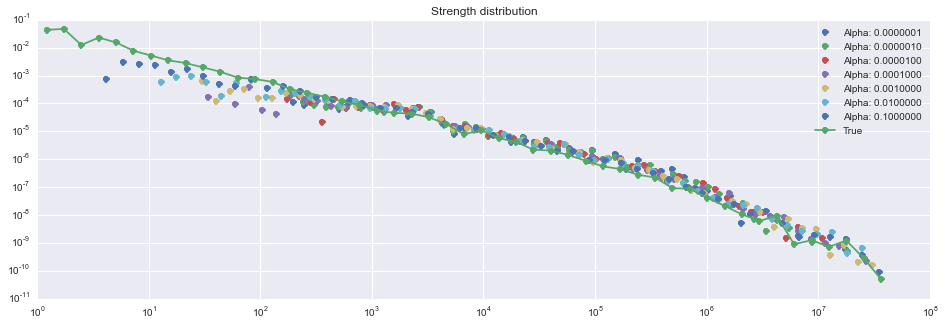

In [24]:
# Strength distribution
plt.figure(figsize=(16,5))
for alpha in alphas:
    G_backbone = get_backbone_graph(G,alpha)
    print 'alpha: %s (%1.2f%% nodes)' % (alpha, 100.*G_backbone.number_of_nodes()/N)
    strengths_backbone = G_backbone.degree(weight='weight').values()
    x,y = get_binning(strengths_backbone,log_binning=True)
    __ = plt.loglog(x,y,'o',label='Alpha: %1.7f' % alpha)

x,y = get_binning(stats['strength'],log_binning=True)
__ = plt.loglog(x,y,'-o',label='True')
    
plt.legend()
    
plt.title("Strength distribution")

alpha: 1e-07 (25.22% nodes)
alpha: 1e-06 (28.84% nodes)
alpha: 1e-05 (32.66% nodes)
alpha: 0.0001 (38.44% nodes)
alpha: 0.001 (45.62% nodes)
alpha: 0.01 (52.92% nodes)
alpha: 0.1 (63.79% nodes)


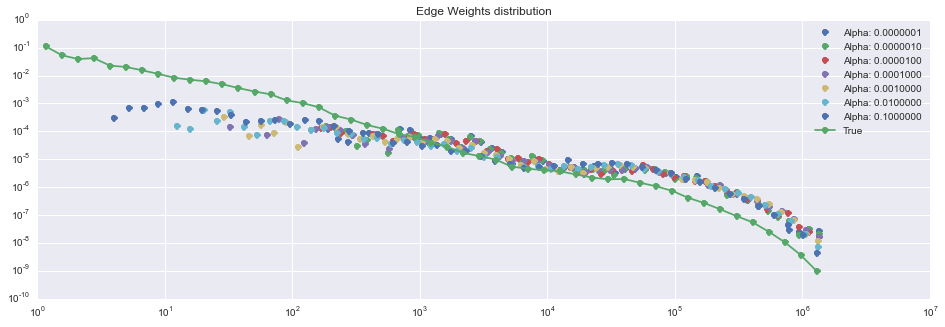

In [25]:
# Edge weights distribution
plt.figure(figsize=(16,5))
for alpha in alphas:
    G_backbone = get_backbone_graph(G,alpha)
    print 'alpha: %s (%1.2f%% nodes)' % (alpha, 100.*G_backbone.number_of_nodes()/N)
    weights_backbone = nx.get_edge_attributes(G_backbone,'weight').values()
    x,y = get_binning(weights_backbone,log_binning=True)
    __ = plt.loglog(x,y,'o',label='Alpha: %1.7f' % alpha)

weights_original = nx.get_edge_attributes(G,'weight').values()
x,y = get_binning(weights_original,log_binning=True)
__ = plt.loglog(x,y,'-o',label='True')
    
plt.legend()
    
plt.title("Edge Weights distribution")

In [ ]:


def disparity_filter(G):
    ''' Compute significance scores (alpha) for weighted edges in G as defined in Serrano et al. 2009
        Args
            G: Weighted NetworkX graph
        Returns
            Weighted graph with a significance score (alpha) assigned to each edge
        References
            M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 106:16, pp. 6483-6488.
    '''
    B = nx.Graph()
    for u in G:
        k = len(G[u])
        if k > 1:
            sum_w = sum(G[u][v]['weight'] for v in G[u])
            for v in G[u]:
                w = G[u][v]['weight']
                p_ij = float(w)/sum_w
                alpha_ij = 1 - (k-1) * integrate.quad(lambda x: (1-x)**(k-2), 0, p_ij)[0]
                B.add_edge(u, v, weight=w, alpha=float('%.4f' % alpha_ij))
    return B
                
            

# Next Class: Community Detection!

# References

* Alvarez-Hamelin, J. I., Dall'Asta, L., Barrat, A., & Vespignani, A. (2005). k-core decomposition: A tool for the visualization of large scale networks. arXiv preprint cs/0504107.
* Bonanno, G., Caldarelli, G., Lillo, F., & Mantegna, R. N. (2003). Topology of correlation-based minimal spanning trees in real and model markets. Physical Review E, 68(4), 046130.
* Daqing, L., Kosmidis, K., Bunde, A., & Havlin, S. (2011). Dimension of spatially embedded networks. Nature Physics, 7(6), 481-484.
* Gfeller, D., & De Los Rios, P. (2007). Spectral coarse graining of complex networks. Physical review letters, 99(3), 038701.
* Graham, R. L., & Hell, P. (1985). On the history of the minimum spanning tree problem. Annals of the History of Computing, 7(1), 43-57.
* Radicchi, F., Ramasco, J. J., & Fortunato, S. (2011). Information filtering in complex weighted networks. Physical Review E, 83(4), 046101.
* Seidman, S. B. (1983). Network structure and minimum degree. Social networks, 5(3), 269-287.
* Serrano, M. Á., Boguná, M., & Vespignani, A. (2009). Extracting the multiscale backbone of complex weighted networks. Proceedings of the national academy of sciences, 106(16), 6483-6488.
* Serrano, M. Á., Boguñá, M., & Sagués, F. (2012). Uncovering the hidden geometry behind metabolic networks. Molecular BioSystems, 8(3), 843-850.
* Tumminello, M., Aste, T., Di Matteo, T., & Mantegna, R. N. (2005). A tool for filtering information in complex systems. Proceedings of the National Academy of Sciences of the United States of America, 102(30), 10421-10426.